In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
#import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow
import tensorflow as tf

import keras
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

# tf.keras.optimizers.legacy.SGD
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [83]:
print(tf.__version__)

2.13.0-rc1


In [84]:
print(keras.__version__)

2.13.1rc0


In [85]:
base_skin_dir = 'archive/'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# skrink dataset
print(f"Original Size: {skin_df.shape}")
skin_df = skin_df.sample(frac=0.01) # shuffle the dataset
print(f"Shrunk Size: {skin_df.shape}")

skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

input_shape = (75, 100, 3)
num_classes = 7

Original Size: (10015, 10)
Shrunk Size: (100, 10)


All of a sudden working when I trained a new model without changing anything except the name of the model to be saved. I am not sure what was the issue but it is working now. I added when I loaded the compile to be false. However, when I tried loading other previously saved models with compile false get same input batch size error. 

In [86]:
model = tf.keras.models.load_model('model_adam.keras', compile=False)

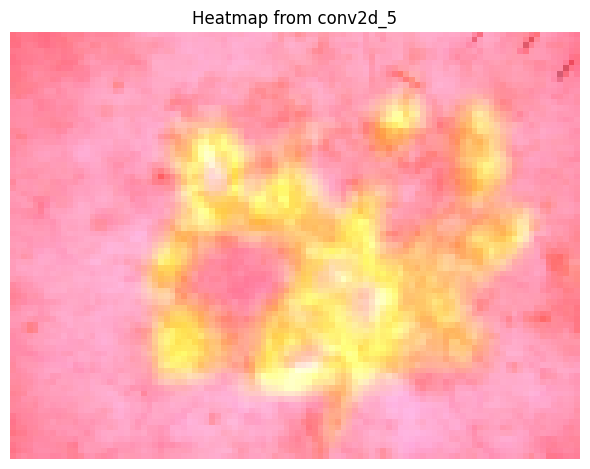

In [87]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the top predicted class with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes (average the gradients)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to superimpose the heatmap onto the original image
def superimpose_heatmap(heatmap, img_array, alpha=0.6):
    img = img_array[0]

    # Convert heatmap to RGB using the 'hot' colormap to avoid blue tint
    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.cm.hot(heatmap)[:, :, :3]  # Apply the 'hot' colormap (no blue)

    # Resize heatmap to match the image dimensions
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=0), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)  # Remove the batch dimension

    # Superimpose the heatmap onto the image
    superimposed_img = heatmap * alpha + img / 255.0  # Normalize image to [0, 1]
    superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values between 0 and 1
    return superimposed_img

# Rescale function to undo normalization for proper image display
def rescale_image(img, mean, std):
    img_rescaled = (img * std) + mean  # Undo normalization
    img_rescaled = np.clip(img_rescaled, 0, 255).astype('uint8')  # Ensure pixel values are in range [0, 255]
    return img_rescaled

# Example: specify a single convolutional layer you want to visualize
conv_layer = "conv2d_5"  # Replace this with your desired layer

# Select an image from the test set
img = x_test[9]  # Example: Pick the 11th image from the test set
img_rescaled = rescale_image(img, x_test_mean, x_test_std)  # Rescale image

# Expand dimensions for Grad-CAM
img_expanded = np.expand_dims(img, axis=0)

# Generate Grad-CAM heatmap for the specific layer
heatmap = make_gradcam_heatmap(img_expanded, model, conv_layer)

# Superimpose the heatmap on the rescaled image
superimposed_img = superimpose_heatmap(heatmap, np.expand_dims(img_rescaled, axis=0))

# Plot the original image and the superimposed heatmap
plt.figure(figsize=(6, 6))

# Display the original rescaled image
'''plt.subplot(1, 2, 1)
plt.imshow(img_rescaled)
plt.title('Original Image')
plt.axis('off')'''

# Display the heatmap over the rescaled image
#plt.subplot(1, 2, 2)
plt.plot()
plt.imshow(superimposed_img)
plt.title(f'Heatmap from {conv_layer}')
plt.axis('off')

plt.tight_layout()
plt.show()

ValueError: No such layer: conv2d_36. Existing layers are: ['conv2d_4', 'max_pooling2d_4', 'dropout_5', 'conv2d_5', 'max_pooling2d_5', 'dropout_6', 'conv2d_6', 'max_pooling2d_6', 'dropout_7', 'conv2d_7', 'max_pooling2d_7', 'dropout_8', 'flatten_1', 'dense_2', 'dropout_9', 'dense_3'].

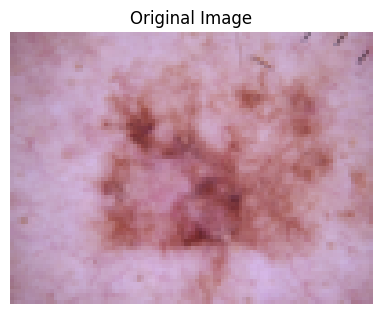

In [88]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the top predicted class with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes (average the gradients)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to superimpose the heatmap onto the original image
def superimpose_heatmap(heatmap, img_array, alpha=0.6):
    img = img_array[0]

    # Convert heatmap to RGB using the 'hot' colormap to avoid blue tint
    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.cm.hot(heatmap)[:, :, :3]  # Apply the 'hot' colormap (no blue)

    # Remove low-activation areas by setting them to 0 (transparent)
    heatmap = np.where(heatmap < 0.2, 0, heatmap)  # Threshold for low activations (adjustable)

    # Resize heatmap to match the image dimensions
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=0), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)  # Remove the batch dimension

    # Superimpose the heatmap onto the image
    superimposed_img = heatmap * alpha + img / 255.0  # Normalize image to [0, 1]
    superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values between 0 and 1
    return superimposed_img

# Rescale function to undo normalization for proper image display
def rescale_image(img, mean, std):
    img_rescaled = (img * std) + mean  # Undo normalization
    img_rescaled = np.clip(img_rescaled, 0, 255).astype('uint8')  # Ensure pixel values are in range [0, 255]
    return img_rescaled

# List of convolutional layers to visualize
conv_layers = ["conv2d_36", "conv2d_37", "conv2d_38", "conv2d_39"]

# Select an image from the test set
img = x_test[9]  # Example: Pick the 11th image from the test set
img_rescaled = rescale_image(img, x_test_mean, x_test_std)  # Rescale image

# Expand dimensions for Grad-CAM
img_expanded = np.expand_dims(img, axis=0)

# Plot original image and heatmaps for each convolutional layer
plt.figure(figsize=(12, 12))

# Display the original rescaled image in the first subplot
plt.subplot(3, 2, 1)
plt.imshow(img_rescaled)
plt.title('Original Image')
plt.axis('off')

# Loop through convolutional layers and generate heatmaps
for i, conv_layer in enumerate(conv_layers):
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_expanded, model, conv_layer)
    
    # Superimpose the heatmap on the rescaled image
    superimposed_img = superimpose_heatmap(heatmap, np.expand_dims(img_rescaled, axis=0))
    
    # Display the heatmap over the rescaled image
    plt.subplot(3, 2, i + 2)
    plt.imshow(superimposed_img)
    plt.title(f'Heatmap from {conv_layer}')
    plt.axis('off')

plt.tight_layout()
plt.show()